## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0
print(sys)

E_reco


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.1 s, sys: 184 ms, total: 6.28 s
Wall time: 6.3 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()


# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
if sys == "E_reco":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
    dataset_asimov_N.irf_model.parameters['norm'].frozen = True
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 1000

    
        
if  "Combined" in sys:
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    dataset_asimov_N.irf_model.parameters['norm'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 1000

try:
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    path = f'../{folder}/data/0_model_livetime_{livetime}_np.yml'
    dataset_asimov.models = Models.read(path)
except:
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}_{e_reco_n}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
print(dataset_asimov.models)

DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.227  +/-    0.09             
    amplitude                  :   4.06e-11  +/- 2.5e-12 1 / (cm2 s TeV)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.138  +/-    0.04 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0                      :    329.680  +/-    0.00 deg         
    lat_0                      :    -30.222  +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-bkg
  Datasets names            : ['dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                       :      1.000  +/-    0.01             


## Minos

In [6]:
parameter_names = c['parameter_names']
source = 'Crablog'
scan_n_sigma = 2
scan_n_values = 5
e_reco_n = 1000

if "Eff_area" in sys:
    scan_n_sigma = 2
    scan_n_values = 5
    e_reco_n = 10



In [7]:
def computing_surface(dataset_asimov, note, idx):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset_asimov)
    result_cor.minuit
    print(dataset_asimov.models[0])
    
    results = []
    for parname1, parname2 in parameter_names[idx:idx+1] :
        print( parname1, parname2)
        dataset_asimov.models.parameters[parname1].scan_n_sigma  = scan_n_sigma  
        dataset_asimov.models.parameters[parname2].scan_n_sigma  = scan_n_sigma 
        
        dataset_asimov.models.parameters[parname1].scan_n_values  = scan_n_values  
        dataset_asimov.models.parameters[parname2].scan_n_values  = scan_n_values 
        par1_scan = dataset_asimov.models.parameters[parname1].scan_values
        par2_scan = dataset_asimov.models.parameters[parname2].scan_values

        print(par1_scan)
        print(par2_scan)
        
        
        if dataset_asimov.models.parameters[parname1].scan_min <0:
            dataset_asimov.models.parameters[parname1].scan_min = 1e-15
        if dataset_asimov.models.parameters[parname2].scan_min <0:
            dataset_asimov.models.parameters[parname2].scan_min = 1e-15
            
            
        dataset_asimov.models.parameters[parname1].frozen  = True
        dataset_asimov.models.parameters[parname2].frozen  = True
        dataset_asimov.models.parameters['lon_0'].frozen = True
        dataset_asimov.models.parameters['lat_0'].frozen = True
        kk =0 
        stat_scans_N = []
        for a in par1_scan:
            dataset_asimov.models.parameters[parname1].value = a
            for i in par2_scan:
                print(kk)
                dataset_asimov.models.parameters[parname2].value = i
                fit_cor = Fit(store_trace=False)
                result_cor = fit_cor.run(dataset_asimov)
                print(result_cor.minuit)
                print(dataset_asimov.models)
                stat_scans_N.append(dataset_asimov.stat_sum())
                kk +=1
        stat_scans_N = np.array(stat_scans_N) #- np.min(stat_scans_N)    
        print(stat_scans_N)
        dataset_asimov.models.parameters[parname1].frozen  = False
        dataset_asimov.models.parameters[parname2].frozen  = False

        result = dict()
        result[f'Crablog.spectral.{parname1}_scan'] = par1_scan
        result[f'Crablog.spectral.{parname2}_scan'] = par2_scan
        result['stat_scan'] = stat_scans_N.reshape(scan_n_values, scan_n_values)
        #result = fit_cor.stat_surface([dataset],
        #                     dataset.models.parameters[parname1],
        #                     dataset.models.parameters[parname2],
        #                    reoptimize=True)
        print(result)
        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "fit_results":
                contour_write[k] =[float(_) for _ in np.array(result[k]).flatten()]#.tolist()
                
        with open(f"../{folder}/data/3_surface_{note}_{parname1}_{parname2}_{scan_n_sigma}_{scan_n_values}_{e_reco_n}.yml", "w") as outfile:
        #with open(f"../{c['folder']}/data/3_surface_{note}_{parname1}_{parname2}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)
        results.append(result)
    return results

def read_in_surface(note):
    results = []
    for parname1, parname2 in parameter_names :
        with open(f"../{folder}/data/3_surface_{note}_{parname1}_{parname2}_{scan_n_sigma}_{scan_n_values}_{e_reco_n}.yml", "r") as stream:
        #with open(f"../{c['folder']}/data/3_surface_{note}_{parname1}_{parname2}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        a = contour[f"{source}.spectral.{parname1}_scan"]
        b = contour[f"{source}.spectral.{parname2}_scan"]
        shape =len(a) , len(b)
        contour['stat_scan'] = np.array(contour['stat_scan']).reshape(shape)
        results.append(contour)
    return results

In [8]:
%%time
computing = 0
if computing:
    
    results = computing_surface(dataset_asimov, "2.15h", 0)
    results = computing_surface(dataset_asimov, "2.15h", 1)
    results = computing_surface(dataset_asimov, "2.15h", 2)
    
else:
    results = read_in_surface("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)

CPU times: user 26.3 ms, sys: 705 µs, total: 27.1 ms
Wall time: 28.9 ms


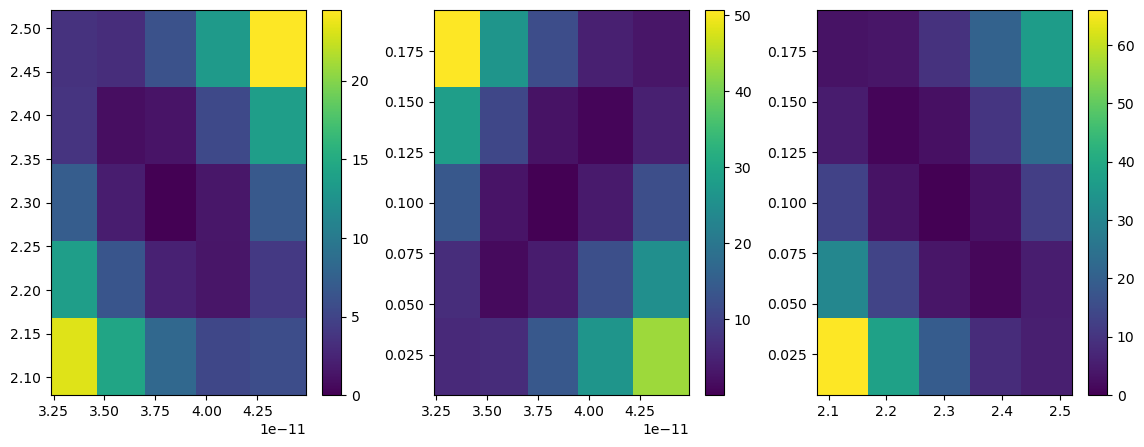

In [9]:
fig, (ax1, ax, ax3) = plt.subplots(1, 3, figsize=(14, 5))
stat_scan = results[0]["stat_scan"] - np.min(results[0]["stat_scan"])


im = ax1.pcolormesh(results[0]['Crablog.spectral.amplitude_scan'],
                    results[0][ 'Crablog.spectral.index_scan'], 
                    stat_scan)
fig.colorbar(im, ax=ax1)

stat_scan = results[1]["stat_scan"] - np.min(results[0]["stat_scan"])

im = ax.pcolormesh(results[1]['Crablog.spectral.amplitude_scan'],
                    results[1][ 'Crablog.spectral.lambda__scan'], 
                    stat_scan)
fig.colorbar(im, ax=ax)


stat_scan = results[2]["stat_scan"] - np.min(results[2]["stat_scan"])

im = ax3.pcolormesh(results[2]['Crablog.spectral.index_scan'],
                    results[2][ 'Crablog.spectral.lambda__scan'], 
                    stat_scan)
fig.colorbar(im, ax=ax3)


In [10]:
idx = 1
for parname1, parname2 in parameter_names[idx:idx+1] :
        print( parname1, parname2)

amplitude lambda_


In [11]:
%%time
computing = 0
scan_n_values = 5

dataset_asimov_N.e_reco_n = e_reco_n
if computing:
    
    results_N = computing_surface(dataset_asimov_N, "N_2.15h", 0)
    results_N = computing_surface(dataset_asimov_N, "N_2.15h", 1)
    #results_N = computing_surface(dataset_asimov_N, "N_2.15h", 2)
else:
    results_N = read_in_surface("N_2.15h")

CPU times: user 7.44 ms, sys: 256 µs, total: 7.69 ms
Wall time: 21.9 ms


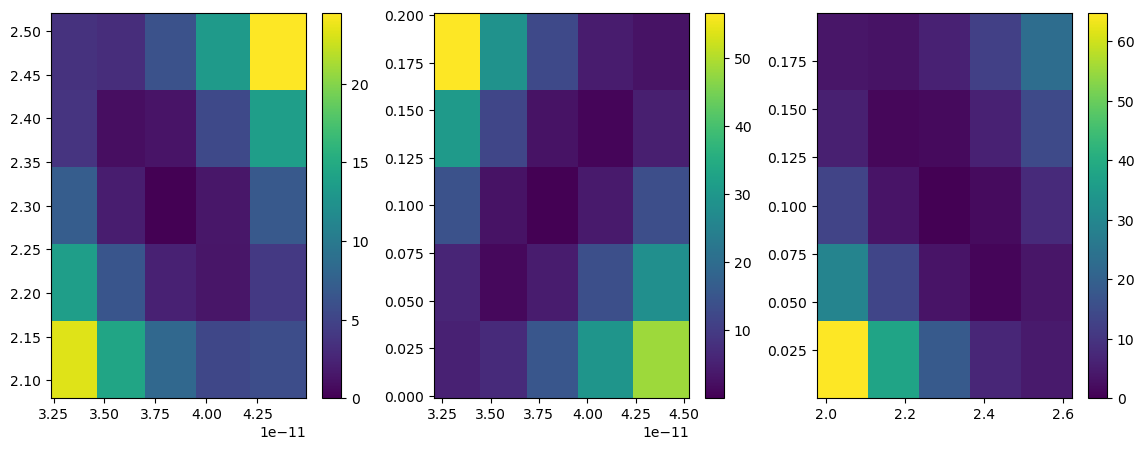

In [12]:
fig, (ax1, ax, ax3) = plt.subplots(1, 3, figsize=(14, 5))
stat_scan = results_N[0]["stat_scan"] - np.min(results_N[0]["stat_scan"])


im = ax1.pcolormesh(results_N[0]['Crablog.spectral.amplitude_scan'],
                    results_N[0][ 'Crablog.spectral.index_scan'], 
                    stat_scan)
fig.colorbar(im, ax=ax1)

stat_scan = results_N[1]["stat_scan"] - np.min(results[0]["stat_scan"])

im = ax.pcolormesh(results_N[1]['Crablog.spectral.amplitude_scan'],
                    results_N[1][ 'Crablog.spectral.lambda__scan'], 
                    stat_scan)
fig.colorbar(im, ax=ax)


stat_scan = results_N[2]["stat_scan"] - np.min(results_N[2]["stat_scan"])

im = ax3.pcolormesh(results_N[2]['Crablog.spectral.index_scan'],
                    results_N[2][ 'Crablog.spectral.lambda__scan'], 
                    stat_scan)
fig.colorbar(im, ax=ax3)


In [13]:
def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best


def plot_surface(contour, parname1, parname2,
                source = "Crabbreak", note = "", plot_orig = True, cubic = True):
    cropidx = 0
    amplix__ = contour[f"{source}.spectral.{parname1}_scan"]#[cropidx: -cropidx]
    indexy__ = contour[f"{source}.spectral.{parname2}_scan"]#[cropidx: -cropidx]
    N_new = int(110 * 1)
    N_new_y = int(100 *1)
    amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
    indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)
    stat_scan = contour["stat_scan"] - np.min(contour["stat_scan"])
    stat_scan =stat_scan#[cropidx: -cropidx,cropidx: -cropidx]
    if cubic:
    #try:
        f = interp2d(
            x=indexy__,
            y=amplix__,
            z=stat_scan,
            kind="cubic",
            fill_value=None,
            bounds_error=False,
            )
    else:
    #except:
        f = interp2d(
            x=indexy__,
            y=amplix__,
            z=stat_scan,
            kind="linear",#"cubic",
            fill_value=None,
            bounds_error=False,
            )
    data_contour = f(indexy__new, amplix__new)
    
    

    dddd = np.array(contour["stat_scan"])
    ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
    index_best = indexy__[np.where(dddd == dddd.min())[1][0]]
    if plot_orig:
        fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))
        im = ax1.pcolormesh(indexy__, amplix__, stat_scan)
        
        ax1.plot(index_best, ampli_best, "x")
        fig.colorbar(im, ax=ax1)
        ax1.set_ylabel(parname1)
        ax1.set_xlabel(parname2)
        ax1.set_title("Likelihood")
        ax1.plot(dataset_input.models.parameters[parname2].value, 
                dataset_input.models.parameters[parname1].value,
                "+", color = 'white')
    else:
        fig, ax = plt.subplots(1,1)
    im = ax.pcolormesh(indexy__new, amplix__new, data_contour)
    dddd = np.array(data_contour)
    ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
    index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
    print("min index:", index_best)
    print("min amplitude:", ampli_best)

    ax.plot(index_best, ampli_best, "x")
    ax.errorbar(dataset_input.models.parameters[parname2].value, 
            dataset_input.models.parameters[parname1].value,
                xerr = dataset_input.models.parameters[parname2].error, 
                yerr = dataset_input.models.parameters[parname1].error, 
           fmt =  "+", color = 'white')
    
    fig.colorbar(im, ax=ax)
    ax.set_ylabel(parname1)
    ax.set_xlabel(parname2)
    ax.set_title("Likelihood")
    
    threshold_contour = 1

    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best  = compute_errors(
        data_contour, indexy__new, amplix__new, threshold_contour, find_min=True
    )
    threshold = 1
    CS = ax.contour(
        indexy__new, amplix__new, data_contour,
        colors=('white',), levels=[data_contour.min() + threshold]
    )
    return CS, fig


In [14]:
if c['model'] =="crab_log":
    source = "Crablog"

min index: 2.2982186574252395
min amplitude: 3.8545929428257376e-11
min index: 2.2982186574252395
min amplitude: 3.8545929428257376e-11
min index: 0.09936718971692352
min amplitude: 3.846364581826744e-11
min index: 0.0958289433309688
min amplitude: 3.827876657758725e-11
min index: 2.3052676451046774
min amplitude: 0.09795125378026087
min index: 2.333247469646416
min amplitude: 0.09196654493771811


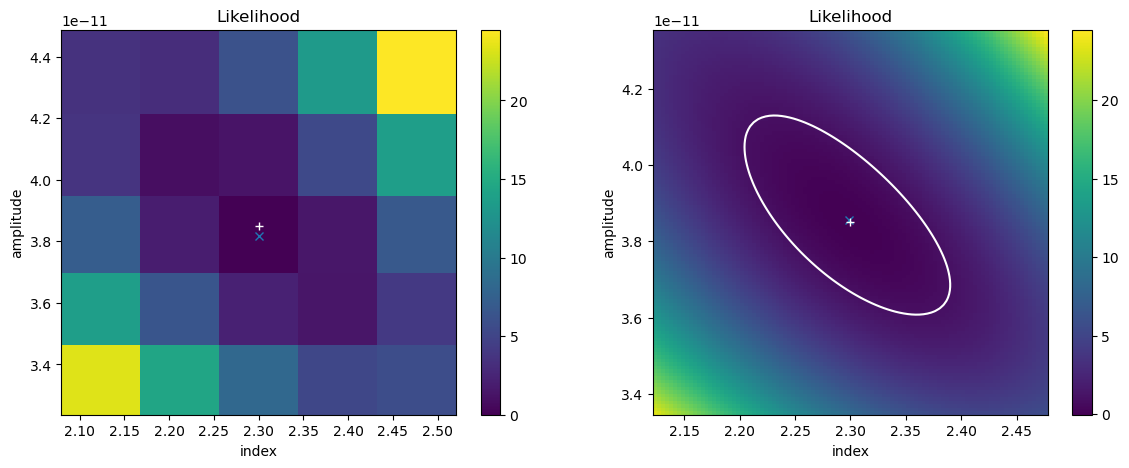

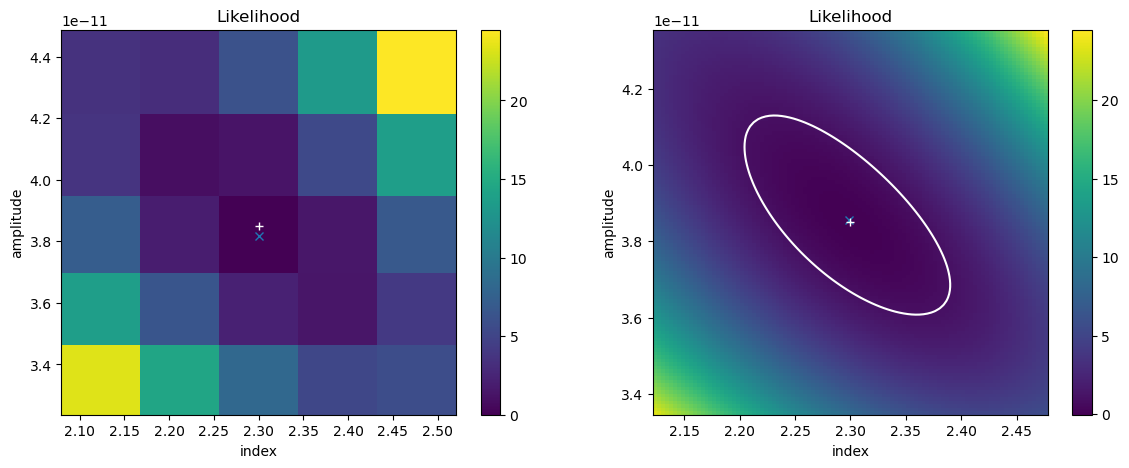

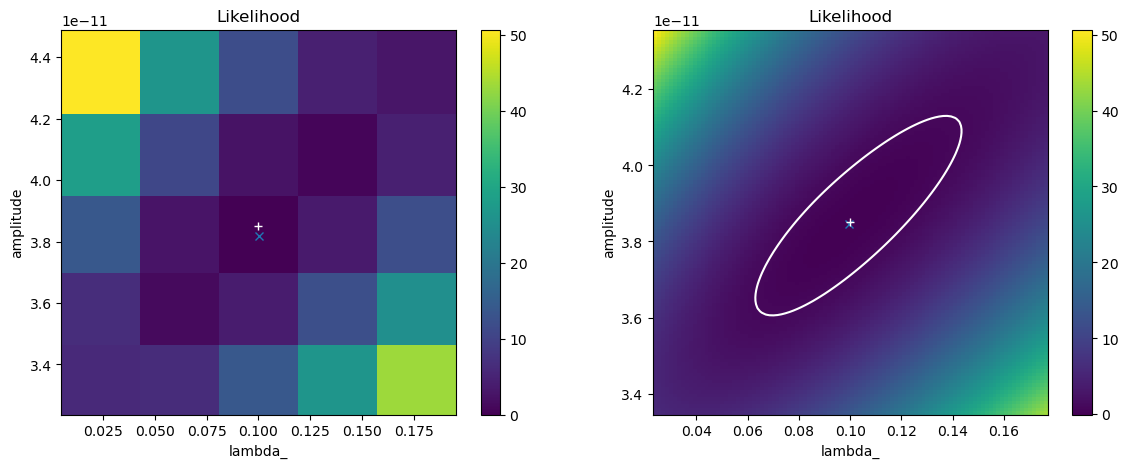

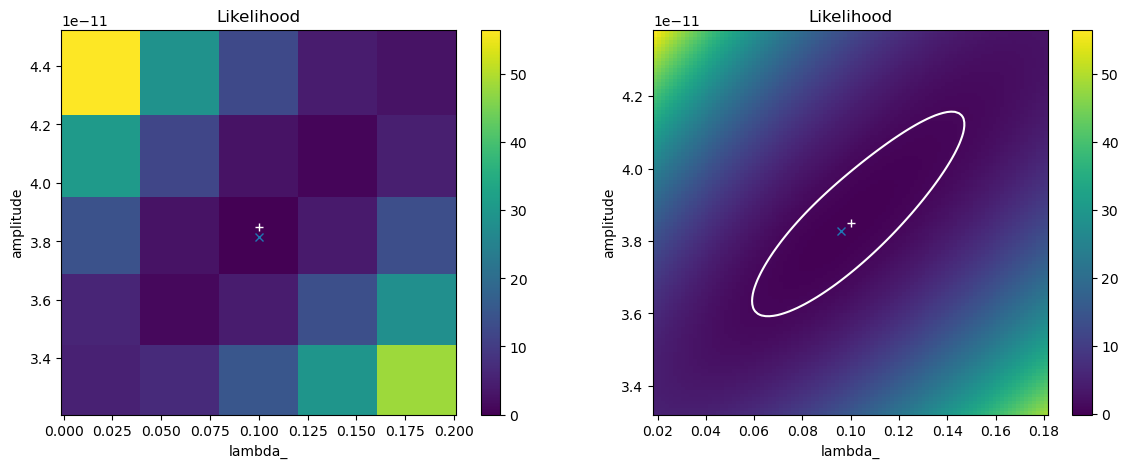

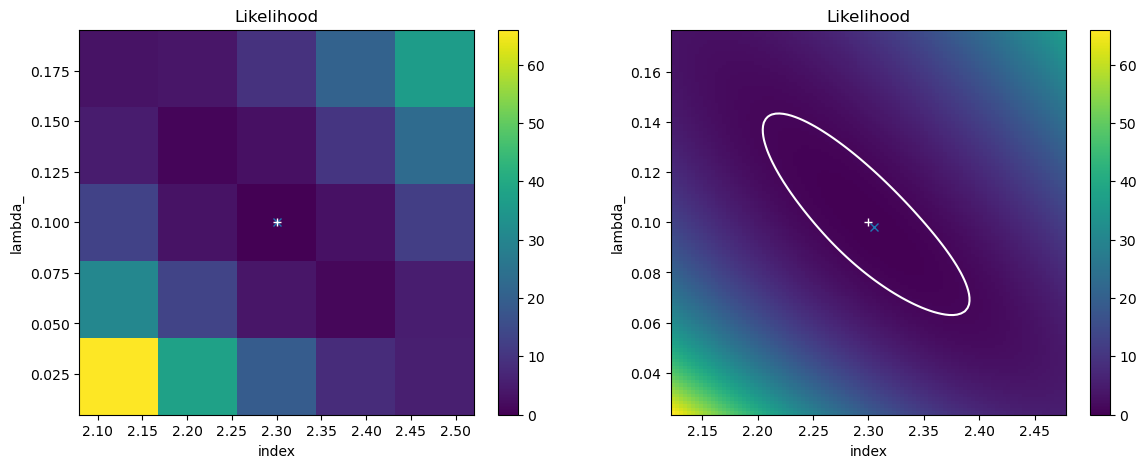

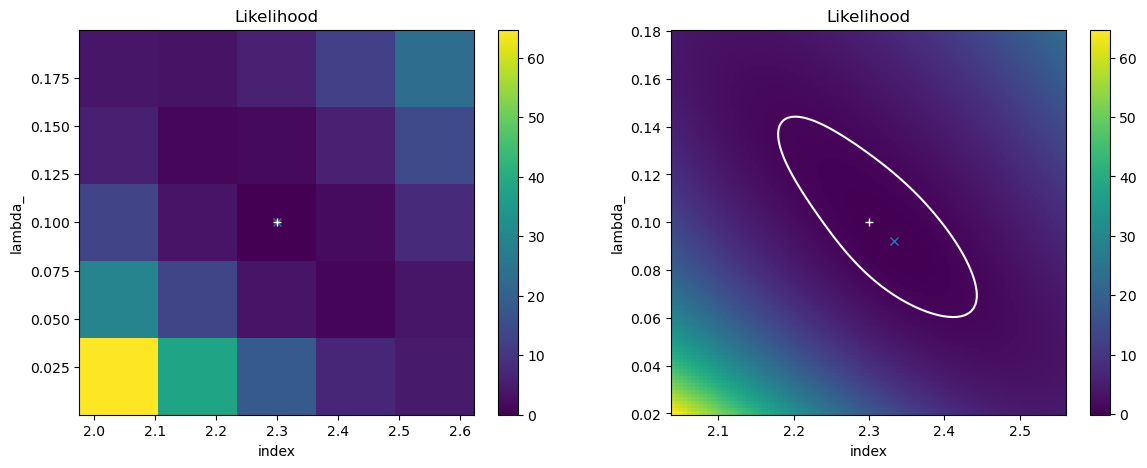

In [15]:
CSs, CS_Ns  = [] , []
cubic = True
for i in range(len(parameter_names)):
#for i in range(1):
    CS, fig  = plot_surface(results[i], parameter_names[i][0], 
             parameter_names[i][1], source = source,plot_orig=1, cubic = cubic)
    fig.savefig(f"../{c['folder']}/plots/3_surface_{i}.pdf")
    CSs.append(CS)
    
    CS_N, fig = plot_surface(results_N[i], parameter_names[i][0], 
             parameter_names[i][1], source = source,plot_orig=1, cubic = cubic)
    
    CS_Ns.append(CS_N)

In [16]:
check_constistency = 0
if check_constistency :
    numpoints = 50      
    def read_in_contour(note, folder = c['folder'], numpoints = numpoints, numpoints2 =numpoints, numpoints3 =numpoints ):
        results = []
        for parname1, parname2 in parameter_names :
            try:
                with open(f"../{folder}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints3}.yml", "r") as stream:
                        contour = yaml.safe_load(stream)
            except:
                try:
                    with open(f"../{folder}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints2}.yml", "r") as stream:
                            contour = yaml.safe_load(stream)
                except:    
                    with open(f"../{folder}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}.yml", "r") as stream:
                            contour = yaml.safe_load(stream)

            results.append(contour)
        return results





    numpoints = 50
    results_contour = read_in_contour("2.15h", numpoints = "5_2000",
                                      numpoints2 = "10_2000", numpoints3 = "20_2000",)   
    results_contour_N = read_in_contour("N_2.15h", numpoints = "5_2000",
                                      numpoints2 = "10_2000", numpoints3 = "20_2000",)

    
    
    fig,axs = plt.subplots(2,2)
    axs = [axs[1][0], axs[1][1], axs[0][0]]
    for i, p in enumerate(parameter_names):
        ax = axs[i]
        dat = CSs[i].allsegs[0][0]
        ax.plot(
            dat[:, 0],
            dat[:, 1],
            color=awo[0],
        )

        dat = CS_Ns[i].allsegs[0][0]
        ax.plot(
            dat[:, 0],
            dat[:, 1],
            color=aw[0],
        )

        ax.set_ylabel(p[0])
        ax.set_xlabel(p[1])
        p1 = dataset_asimov.models.parameters[p[0]]
        p2 = dataset_asimov.models.parameters[p[1]]
        ax.errorbar(p2.value, p1.value,  xerr = p2.error, 
                   yerr = p1.error, color = awo[0], capsize = 4)
        p1 = dataset_asimov_N.models.parameters[p[0]]
        p2 = dataset_asimov_N.models.parameters[p[1]]
        ax.errorbar(p2.value, p1.value,  xerr = p2.error, 
                   yerr = p1.error, color = aw[0], capsize = 4)

        a = results_contour[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results_contour[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        ax.plot(b,a, color = 'pink', linestyle = 'dotted')
        
        a = results_contour_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
        b = results_contour_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
        ax.plot(b,a, color = 'darkblue', linestyle = 'dotted')

    plt.tight_layout()

amplitude index
amplitude lambda_
lambda_ index
amplitude index
amplitude lambda_
lambda_ index


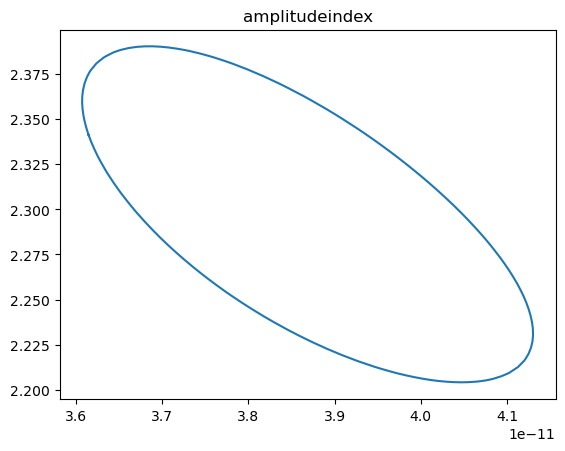

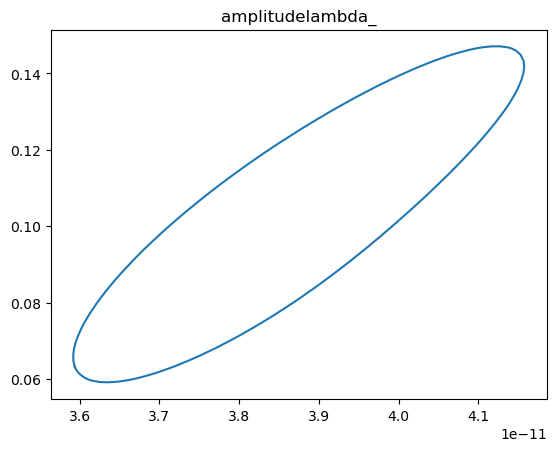

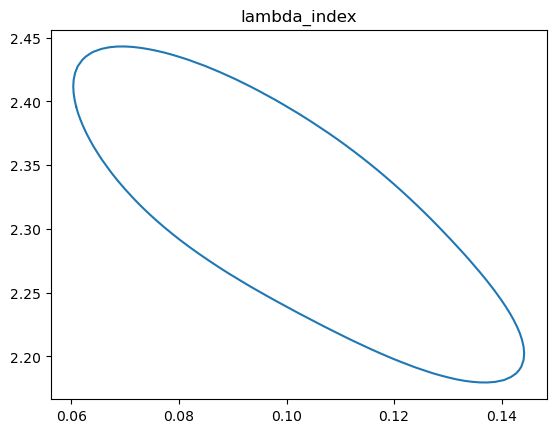

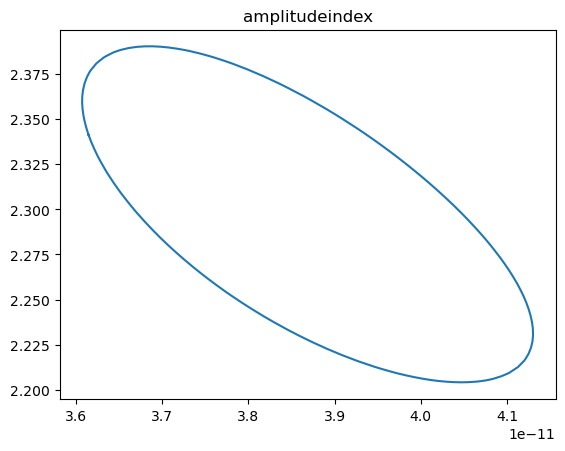

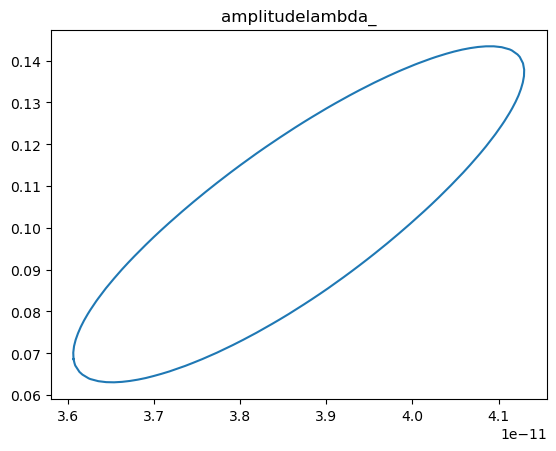

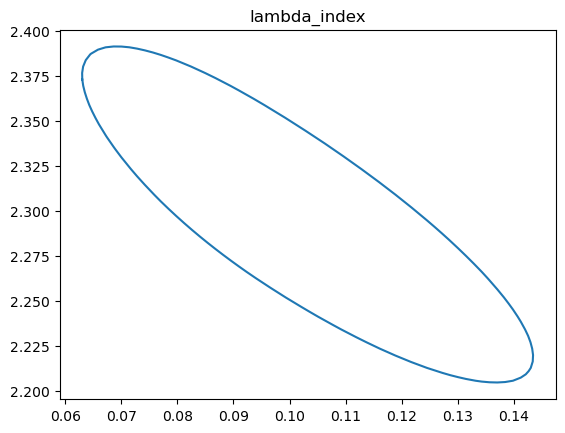

In [17]:
def write(note, CS_Ns):
    i = 0
    for parname1, parname2 in parameter_names :
        print(parname1, parname2)
        fig = plt.figure()
        dat = CS_Ns[i].allsegs[0][0]
        b, a = dat[:, 0], dat[:, 1]
     
        plt.plot(
            a,
            b,
            color=aw[0],
        )
        
        plt.title(parname1 +  parname2)
        result = {}
        result[f'{dataset_asimov.models[0].name}.spectral.{parname1}'] = [float(_) for _ in a]
        result[f'{dataset_asimov.models[0].name}.spectral.{parname2}'] = [float(_) for _ in b]
        
        scan_n_values = 20
        with open(f"../{folder}/data/3_contour_surface_{note}_{parname1}_{parname2}_{scan_n_values}_{e_reco_n}.yml", "w") as outfile:
            yaml.dump(result, outfile, default_flow_style=False)
     
        
        i +=1
write("N_2.15h", CS_Ns)

write("2.15h", CSs)



In [18]:
parameter_names

[['amplitude', 'index'], ['amplitude', 'lambda_'], ['lambda_', 'index']]